# Confident Learning
This notebook reimplement the major processes of [confident learning](https://www.jair.org/index.php/jair/article/download/12125/26676/) along with a toy domain example and shows how to invoke Confident Learning from `cleanlab` with a relatively challenge real-world task. It partly refers to this [blog](https://zhuanlan.zhihu.com/p/488970312) and [code](https://github.com/Christmas-Wong/paper_project/blob/main/) (note that the `cleanlab` invoked in the referring code is outdated).

### Manual Reimplement and Toy Domain Experience
* Generate manual labels.
* Calculate threshold $t_i$, the expected (average) self-confidence for the class $i$.
* Calculate confident joint matrix $C$.
* Calibrate confident joint matrix so that the distribution sums to 1.
* Output potential mislabeled samples. 

In [1]:
import cleanlab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

np.random.seed(0)

In [2]:
p0 = np.random.uniform(0, 1, size=20)
p0 = np.array([round(i, 1) for i in p0])
p1 = 1 - p0
y  = np.random.randint(0, 2, 20)

df_data = pd.DataFrame(dict(p0=p0, p1=p1, y=y))
df_data

,p0,p1,y
0,0.5,0.5,0
1,0.7,0.3,1
2,0.6,0.4,0
3,0.5,0.5,1
4,0.4,0.6,1
5,0.6,0.4,1
6,0.4,0.6,1
7,0.9,0.1,1
8,1.0,0.0,0
9,0.4,0.6,1


#### Calculate Thresholds
The threshold $t_j$ is the expected (average) self-confidence for each class $j$, *i.e.,*
$$t_j=\frac{1}{|X_{\tilde{y}=j}|} \sum_{x\in X_{\tilde{y}=j}} \hat{p}(\tilde{y}=j;x,\theta),$$
where $\tilde{y}$ is the given label with noise.

In [3]:
n = [0, 0]
t = [0, 0]
for index, column in df_data.iterrows():
    if column['y'] == 0:
        n[0] += 1
        t[0] += column['p0']
    elif column['y'] == 1:
        n[1] += 1
        t[1] += column['p1']
    else:
        raise ValueError(f"unknown label '{column['y']}'.")
t[0] = t[0] / n[0]
t[1] = t[1] / n[1]
t

[0.6571428571428573, 0.46923076923076923]

#### Calculate Confident Joint Matrix
The definition of the confident joint $C_{\tilde{y},y^*}$ estimates $X_{\tilde{y}=i,y^*=j}$,the set of examples with noisy label $i$ that actually have true label $j$,by partitioning $X$ into estimate bins $\hat{X}_{\tilde{y}=i,y^*=j}$. Formally, the definition of the confident joint is,
$$C_{\tilde{y},y^*}[i][j]:=|\hat{X}_{\tilde{y}=i,y^*=j}|,$$
where,
$$\hat{X}_{\tilde{y}=i,y^*=j}:= \left\{ x\in X_{\tilde{y}=i}: \hat{p}(\tilde{y}=j;x,\theta)\geq t_j, j=\mathop{\arg\max}_{l\in[m]:\hat{p}(\tilde{y}=l;x,\theta)\geq t_l} \hat{p}(\tilde{y}=l;x,\theta) \right\}$$


In [4]:
C = pd.DataFrame(dict(true_0=[0, 0], true_1=[0, 0]), index=["pred_0", "pred_1"])
    
for index, column in df_data.iterrows():
    # true label is `0`.
    if column['p0'] > column['p1'] and column['p0'] > t[0]:
        # given label is `0`.
        if column['y'] == 0:
            C.loc["pred_0", "true_0"] += 1
        # given label is `1`.
        if column['y'] == 1:
            C.loc["pred_1", "true_0"] += 1
    # true label is `1`.
    if column['p1'] > column['p0'] and column['p1'] > t[1]:
        # given label is `0`.
        if column['y'] == 0:
            C.loc["pred_0", "true_1"] += 1
        # given label is `1`.
        if column['y'] == 1:
            C.loc["pred_1", "true_1"] += 1

C

,true_0,true_1
pred_0,4,1
pred_1,4,5


#### Calibrate Confident Joint Matrix
When counting the number of real labels, the samples whose probability is lower than the threshold are excluded, leading to the change of distribution in the confident joint matrix. So we need to calibrate the matrix to be the same as the original distribution by,
$$\hat{Q}_{\tilde{y}=i,y^*=j} = \frac{\frac{C_{\tilde{y}=i,y^*=j}}{\sum_{j\in[m]} C_{\tilde{y}=i,y^*=j}} \cdot |X_{\tilde{y}=i}|}{\sum_{i\in[m], j\in[m]} \left( \frac{C_{\tilde{y}=i,y^*=j}}{\sum_{j'\in[m]} C_{\tilde{y}=i,y^*=j'}} \cdot |X_{\tilde{y}=i|} \right)}.$$

In [5]:
Q = C.copy()
# calculate numerator.
# for each predicted class `i`.
for index, column in C.iterrows():
    y_ij = column["true_0"] + column["true_1"]  # denominator in the numerator.
    Q.loc[index, 'true_0'] = n[0] * column["true_0"] / y_ij
    Q.loc[index, 'true_1'] = n[0] * column["true_1"] / y_ij
Q

,true_0,true_1
pred_0,5.600000,1.400000
pred_1,3.111111,3.888889


In [6]:
# devided by the denominator.
Q = Q / Q.values.sum()
assert Q.values.sum() == 1.0
Q

,true_0,true_1
pred_0,0.400000,0.100000
pred_1,0.222222,0.277778


#### Conduct Confident Learning by `cleanlab`
The authors proposed five approaches for finding mislabeled data based on the calibrated confident joint matrix $Q$ in their paper. To simplify, here I implement these approaches via `cleanlab` rather than reimplementing them.

In [7]:
y_true = df_data['y'].values
y_pred = np.c_[df_data['p0'].values, df_data['p1'].values]

In [8]:
# Method 3：Prune by Class (PBC)
cl_pbc = cleanlab.filter.find_label_issues(
    y_true,
    y_pred,
    filter_by='prune_by_class',
    return_indices_ranked_by='self_confidence'
)
print(f"The index of error samples discriminated by PBC are: {','.join([str(i) for i in cl_pbc])}.")

# Method 4：Prune by Noise Rate (PBNR)
cl_pbnr = cleanlab.filter.find_label_issues(
    y_true,
    y_pred,
    filter_by='prune_by_noise_rate',
    return_indices_ranked_by='self_confidence'
)
print(f"The index of error samples discriminated by PBNR are: {','.join([str(i) for i in cl_pbnr])}.")

# Method 5：C+NR
cl_both = cleanlab.filter.find_label_issues(
    y_true,
    y_pred,
    filter_by='both',
    return_indices_ranked_by='self_confidence'
)
print(f"The index of error samples discriminated by C+NR are: {','.join([str(i) for i in cl_both])}.")

The index of error samples discriminated by PBC are: 7,13,19,15,1,5.
The index of error samples discriminated by PBNR are: 7,13,19,15,1,5.
The index of error samples discriminated by C+NR are: 7,13,19,15,1,5.


In [9]:
# mislabeled samples.
df_data.loc[cl_both]

,p0,p1,y
7,0.9,0.1,1
13,0.9,0.1,1
19,0.9,0.1,1
15,0.1,0.9,0
1,0.7,0.3,1
5,0.6,0.4,1


### A Real-World Task
Now I use `cleanlab` to detect label issue in CIFAR-10, a real-world image classification dataset. I first use `cleanlab` to detect label issue on the original dataset to see if there is any mislableled sample in the original CIFAR-10 dataset. Then I flipping 20% of labels to investigate its ability in detecting label issue.

In [10]:
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models.resnet as resnet
from torch.utils.data import DataLoader, Subset, TensorDataset

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [11]:
bs = 512
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10('/home/wupj/data/cv/CIFAR-10', train=True, transform=transform)
testset  = torchvision.datasets.CIFAR10('/home/wupj/data/cv/CIFAR-10', train=False, transform=transform)

#### Detect Label Issues in Original CIFAR-10 Dataset

In [12]:
# set resnet 18 and traing arguments.
epoch = 50
lr    = 1e-3
model = resnet.resnet18()
model.conv1 = nn.Conv2d(3, 64, kernel_size=3,  stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, 10)
nn.init.kaiming_normal_(model.conv1.weight, mode="fan_out", nonlinearity="relu")

# cross-validation setting.
cv = 10
index = np.random.choice(len(trainset), len(trainset), replace=False)
index = np.array_split(index, cv)

# result vectors.
y_true = list()
probs  = list()

In [13]:
# start cross-validation predection.
for k in tqdm(range(cv)):
    # split dataset into k-fold.
    k_train_idx = np.concatenate(index[:k] + index[k+1:])
    k_valid_idx = index[k]
    k_trainset  = Subset(trainset, k_train_idx)
    k_validset  = Subset(trainset, k_valid_idx)
    trainloader = DataLoader(k_trainset, batch_size=bs, shuffle=True)
    validloader = DataLoader(k_validset, batch_size=bs, shuffle=False)

    # create an independent model for each fold.
    m = deepcopy(model).to(device)
    optimizer = torch.optim.Adam(m.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # training.
    for e in range(epoch):
        m.train()
        for x, y in trainloader:
            x, y = x.to(device), y.to(device) 
            optimizer.zero_grad()
            logistic = m(x)
            loss = criterion(logistic, y)
            loss.backward()
            optimizer.step()
    # validation.
    m.eval()
    batch_loss, batch_acc = 0, 0
    for x, y in validloader:
        with torch.no_grad():
            x, y = x.to(device), y.to(device)
            logistic = F.softmax(m(x), dim=-1)
            loss = criterion(logistic, y)
        probs.append(logistic.cpu().numpy()) # store validation probability.
        y_true.append(y.cpu().numpy()) # store true labels.
        batch_loss += loss.item()
        batch_acc  += torch.argmax(logistic, dim=1).eq(y).sum().item() / y.size(0)
    batch_loss /= len(validloader)
    batch_acc  /= len(validloader) / 100
    print(f'{k+1}-Fold - Epoch {epoch}: val loss = {batch_loss:.5f}; val acc = {batch_acc:.3f}%.')

  0%|          | 0/10 [00:00<?, ?it/s]

1-Fold - Epoch 50: val loss = 1.62079; val acc = 84.178%.
2-Fold - Epoch 50: val loss = 1.61405; val acc = 84.608%.
3-Fold - Epoch 50: val loss = 1.60950; val acc = 85.143%.
4-Fold - Epoch 50: val loss = 1.63238; val acc = 82.889%.
5-Fold - Epoch 50: val loss = 1.64190; val acc = 82.331%.
6-Fold - Epoch 50: val loss = 1.61664; val acc = 84.580%.
7-Fold - Epoch 50: val loss = 1.66155; val acc = 80.205%.
8-Fold - Epoch 50: val loss = 1.61742; val acc = 84.351%.
9-Fold - Epoch 50: val loss = 1.64028; val acc = 82.333%.
10-Fold - Epoch 50: val loss = 1.62085; val acc = 84.260%.


In [14]:
probs  = np.concatenate(probs, axis=0)
y_true = np.concatenate(y_true, axis=0)
probs[np.concatenate(index, axis=0)]  = probs
y_true[np.concatenate(index, axis=0)] = y_true

cl_both = cleanlab.filter.find_label_issues(
    labels=y_true,
    pred_probs=probs,
    filter_by='both',
    return_indices_ranked_by='self_confidence'
)
print(f'detected {len(cl_both)} error training samples.')
print(f"The top 10 index of error training samples discriminated by C+NR are: {', '.join([str(i) for i in cl_both[:10]])}.")

detected 5530 error training samples.
The top 10 index of error training samples discriminated by C+NR are: 15696, 19257, 36288, 38326, 39785, 8024, 25282, 19222, 48120, 17400.


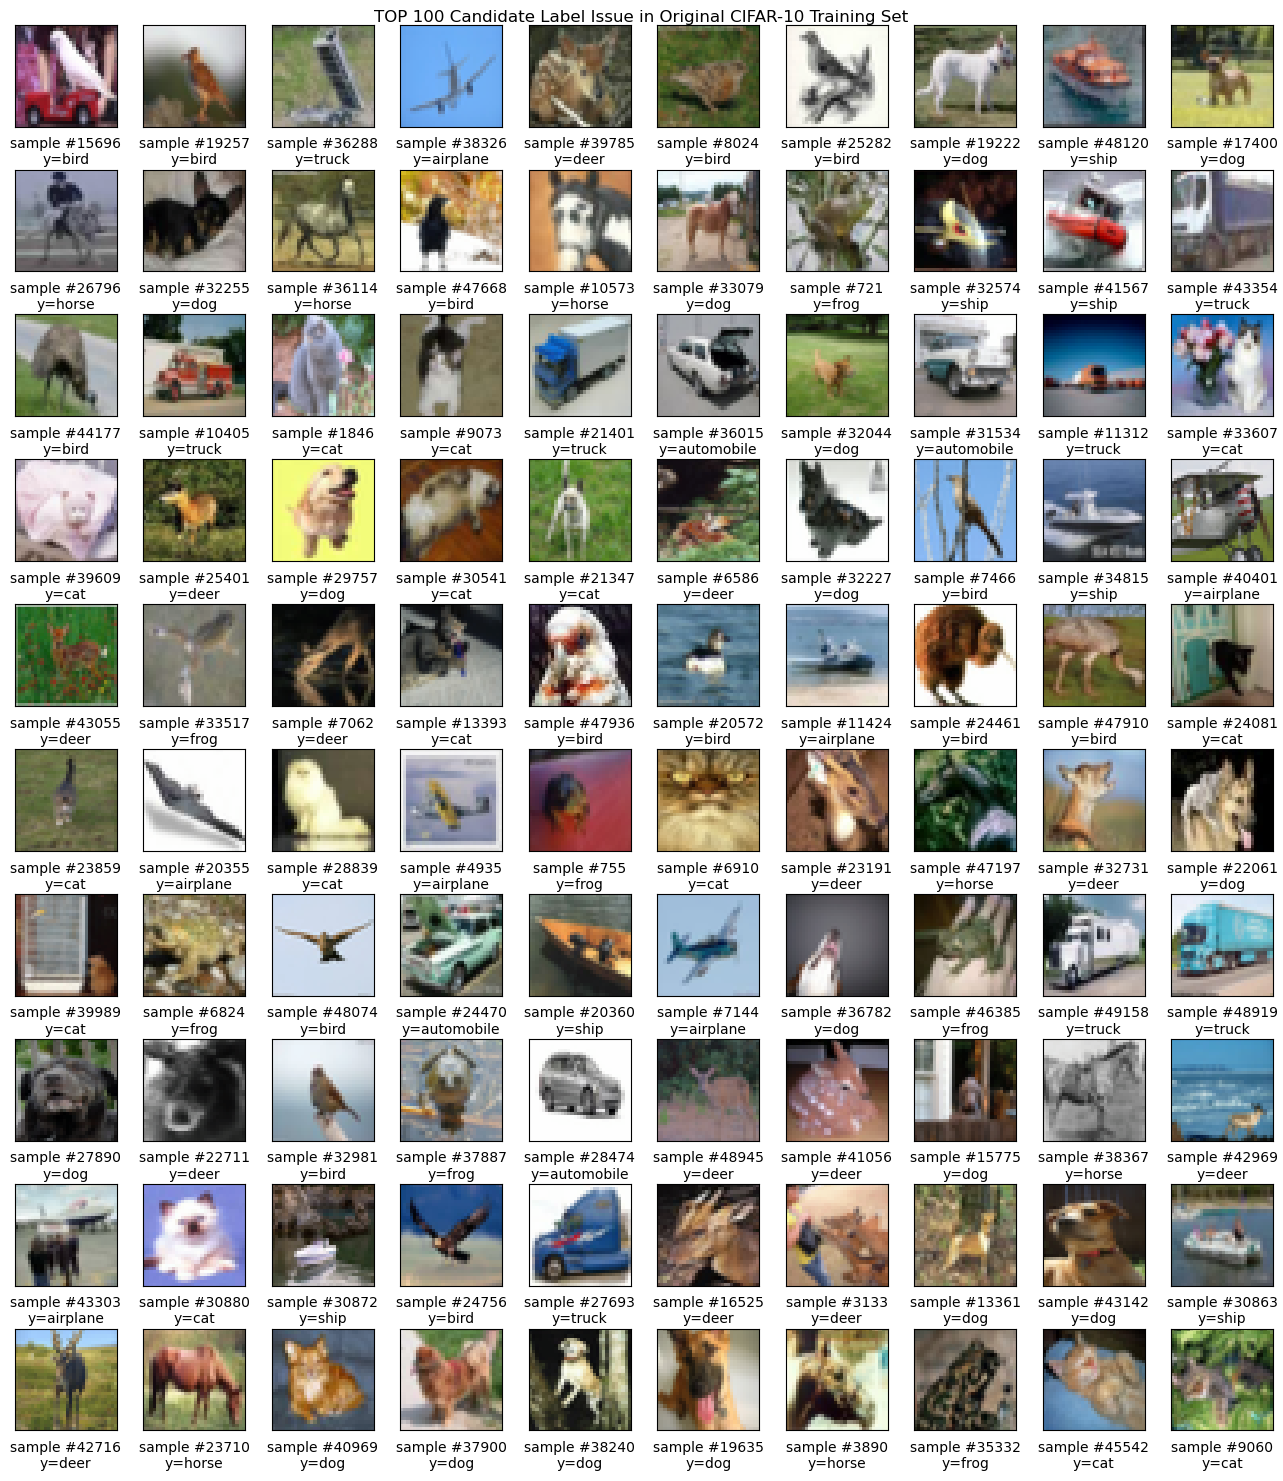

In [15]:
label_issue_data = Subset(trainset, cl_both[:100])
fig, ax = plt.subplots(10, 10, figsize=(13, 15))
fig.suptitle('TOP 100 Candidate Label Issue in Original CIFAR-10 Training Set')
for axi, i, data in zip(ax.flatten(), cl_both[:100], label_issue_data):
    x, y = data[0], data[1]
    x = np.transpose(x.numpy(), (1, 2, 0))
    x = x * np.array([0.2023, 0.1994, 0.2010]) + np.array([0.4914, 0.4822, 0.4465])
    axi.imshow(x.clip(0, 1))
    axi.set_xticks([])
    axi.set_yticks([])
    axi.set_xlabel(f'sample #{i}\ny={trainset.classes[y]}')
fig.tight_layout()
fig.show()

#### Flipping Labels in Training Set
I randomly flip 20% of training set labels and use `cleanlab` to detect mislabeled samples. The result really confused me because it could not find any labeling issues in the training set.

In [16]:
x, noisy_y = [*zip(*[(x, y) for x, y in trainset])]
noisy_y    = np.array(noisy_y)

# flip labels.
label_flip_rate  = 0.2
label_flip_n     = int(len(noisy_y) * label_flip_rate)
label_flip_index = np.random.choice(len(noisy_y), label_flip_n, replace=False)
noisy_y[label_flip_index] = (noisy_y[label_flip_index] + np.random.randint(1, 10, label_flip_n)) % 10
corrupted_trainset = TensorDataset(torch.stack(x), torch.LongTensor(noisy_y))

In [17]:
# set resnet 18 and traing arguments.
model = resnet.resnet18()
model.conv1 = nn.Conv2d(3, 64, kernel_size=3,  stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, 10)
nn.init.kaiming_normal_(model.conv1.weight, mode="fan_out", nonlinearity="relu")

# cross-validation setting.
index = np.random.choice(len(trainset), len(trainset), replace=False)
index = np.array_split(index, cv)

# result vectors.
y_true = list()
probs  = list()

In [18]:
# start cross-validation predection.
for k in tqdm(range(cv)):
    # split dataset into k-fold.
    k_train_idx = np.concatenate(index[:k] + index[k+1:])
    k_valid_idx = index[k]
    k_trainset  = Subset(corrupted_trainset, k_train_idx)
    k_validset  = Subset(corrupted_trainset, k_valid_idx)
    trainloader = DataLoader(k_trainset, batch_size=bs, shuffle=True)
    validloader = DataLoader(k_validset, batch_size=bs, shuffle=False)

    # create an independent model for each fold.
    m = deepcopy(model).to(device)
    optimizer = torch.optim.Adam(m.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # training.
    for e in range(epoch):
        m.train()
        for x, y in trainloader:
            x, y = x.to(device), y.to(device) 
            optimizer.zero_grad()
            logistic = m(x)
            loss = criterion(logistic, y)
            loss.backward()
            optimizer.step()
    # validation.
    m.eval()
    batch_loss, batch_acc = 0, 0
    for x, y in validloader:
        with torch.no_grad():
            x, y = x.to(device), y.to(device)
            logistic = F.softmax(m(x), dim=-1)
            loss = criterion(logistic, y)
        probs.append(logistic.cpu().numpy()) # store validation probability.
        y_true.append(y.cpu().numpy()) # store true labels.
        batch_loss += loss.item()
        batch_acc  += torch.argmax(logistic, dim=1).eq(y).sum().item() / y.size(0)
    batch_loss /= len(validloader)
    batch_acc  /= len(validloader) / 100
    print(f'{k+1}-Fold - Epoch {epoch}: val loss = {batch_loss:.5f}; val acc = {batch_acc:.3f}%.')

  0%|          | 0/10 [00:00<?, ?it/s]

1-Fold - Epoch 50: val loss = 1.89805; val acc = 56.161%.
2-Fold - Epoch 50: val loss = 1.88737; val acc = 57.574%.
3-Fold - Epoch 50: val loss = 1.90579; val acc = 55.658%.
4-Fold - Epoch 50: val loss = 1.90209; val acc = 55.929%.
5-Fold - Epoch 50: val loss = 1.90141; val acc = 56.053%.
6-Fold - Epoch 50: val loss = 1.90159; val acc = 56.020%.
7-Fold - Epoch 50: val loss = 1.90276; val acc = 55.916%.
8-Fold - Epoch 50: val loss = 1.89346; val acc = 56.647%.
9-Fold - Epoch 50: val loss = 1.89555; val acc = 56.307%.
10-Fold - Epoch 50: val loss = 1.89547; val acc = 56.356%.


detected 20115 error training samples.
The top 10 index of error training samples discriminated by C+NR are: 42322,12804,47170,9872,30062,35885,19541,43246,38326,40043.
recall = 0.676, precision = 0.336.


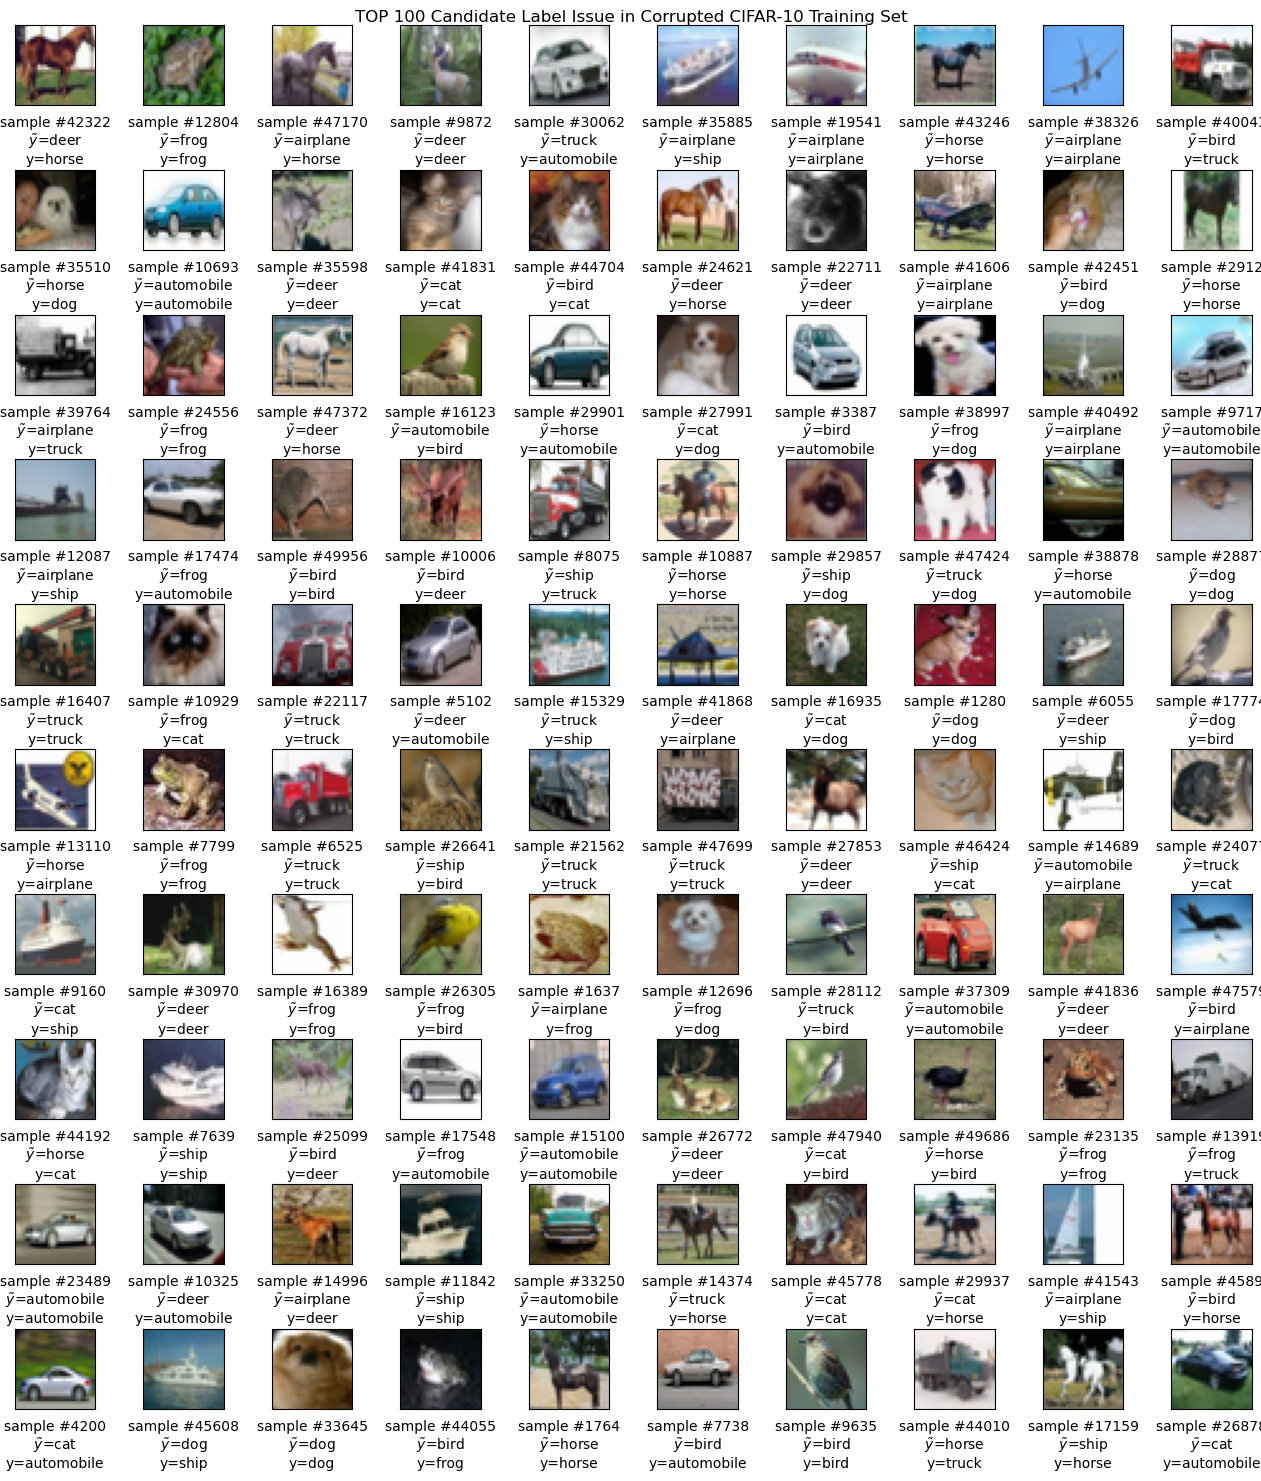

In [19]:
probs  = np.concatenate(probs, axis=0)
y_true = np.concatenate(y_true, axis=0)
probs[np.concatenate(index, axis=0)]  = probs
y_true[np.concatenate(index, axis=0)] = y_true

cl_both = cleanlab.filter.find_label_issues(
    labels=y_true,
    pred_probs=probs,
    filter_by='both',
    return_indices_ranked_by='self_confidence'
)
print(f'detected {len(cl_both)} error training samples.')
print(f"The top 10 index of error training samples discriminated by C+NR are: {','.join([str(i) for i in cl_both[:10]])}.")
print(f'recall = {len(set(label_flip_index).intersection(set(cl_both))) / len(label_flip_index):.3f}, precision = {len(set(label_flip_index).intersection(set(cl_both))) / len(cl_both):.3f}.')

label_issue_data = Subset(corrupted_trainset, cl_both[:100])
fig, ax = plt.subplots(10, 10, figsize=(13, 15))
fig.suptitle('TOP 100 Candidate Label Issue in Corrupted CIFAR-10 Training Set')
for axi, i, data in zip(ax.flatten(), cl_both[:100], label_issue_data):
    x, y = data[0], data[1]
    x = np.transpose(x.numpy(), (1, 2, 0))
    x = x * np.array([0.2023, 0.1994, 0.2010]) + np.array([0.4914, 0.4822, 0.4465])
    axi.imshow(x.clip(0, 1))
    axi.set_xticks([])
    axi.set_yticks([])
    axi.set_xlabel(f'sample #{i}\n$\\tilde y$={trainset.classes[y]}\ny={trainset.classes[trainset[i][1]]}')
fig.tight_layout()
fig.show()

#### Test Model Performance
* Test accuracy of ResNet-18 trained on original CIFAR-10 training set.
* Test accuracy of ResNet-18 trained on corrupted CIFAR-10 training set.
* Test accuracy of ResNet-18 trained on CIFAR-10 training set cleaned by CL.
* Test accuracy of ResNet-18 trained on CIFAR-10 training set cleaned by ground truth.

In [20]:
trainloader = DataLoader(trainset, batch_size=bs, shuffle=True)
testloader  = DataLoader(testset, batch_size=bs, shuffle=False)

model = resnet.resnet18()
model.conv1 = nn.Conv2d(3, 64, kernel_size=3,  stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, 10)
nn.init.kaiming_normal_(model.conv1.weight, mode="fan_out", nonlinearity="relu")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

for e in range(epoch):
    model.train()
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logistic = model(x)
        loss = criterion(logistic, y)
        loss.backward()
        optimizer.step()
    # test.
    if e == 0 or (e + 1) % 10 == 0:
        model.eval()
        batch_loss, batch_acc = 0, 0
        with torch.no_grad():
            for x, y in testloader:
                x, y = x.to(device), y.to(device)
                logistic = F.softmax(model(x), dim=-1)
                loss = criterion(logistic, y)
                batch_loss += loss.item()
                batch_acc  += torch.argmax(logistic, dim=1).eq(y).sum().item() / y.size(0)
        batch_loss /= len(testloader)
        batch_acc  /= len(testloader) / 100
        print(f'Epoch {e+1:2}/{epoch}: test loss = {batch_loss:.5f}; test acc = {batch_acc:.3f}%.')

Epoch  1/50: test loss = 1.97632; test acc = 52.520%.
Epoch 10/50: test loss = 1.69052; test acc = 77.561%.
Epoch 20/50: test loss = 1.66017; test acc = 80.353%.
Epoch 30/50: test loss = 1.65638; test acc = 80.638%.
Epoch 40/50: test loss = 1.63698; test acc = 82.398%.
Epoch 50/50: test loss = 1.62148; test acc = 84.157%.


In [21]:
trainloader = DataLoader(corrupted_trainset, batch_size=bs, shuffle=True)

model = resnet.resnet18()
model.conv1 = nn.Conv2d(3, 64, kernel_size=3,  stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, 10)
nn.init.kaiming_normal_(model.conv1.weight, mode="fan_out", nonlinearity="relu")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

for e in range(epoch):
    model.train()
    for x, y in trainloader:
        x, y = x.to(device), y.to(device) 
        optimizer.zero_grad()
        logistic = model(x)
        loss = criterion(logistic, y)
        loss.backward()
        optimizer.step()
    # test.
    if e == 0 or (e + 1) % 10 == 0:
        model.eval()
        batch_loss, batch_acc = 0, 0
        with torch.no_grad():
            for x, y in testloader:
                x, y = x.to(device), y.to(device)
                logistic = F.softmax(model(x), dim=-1)
                loss = criterion(logistic, y)
                batch_loss += loss.item()
                batch_acc  += torch.argmax(logistic, dim=1).eq(y).sum().item() / y.size(0)
        batch_loss /= len(testloader)
        batch_acc  /= len(testloader) / 100
        print(f'Epoch {e+1:2}/{epoch}: test loss = {batch_loss:.5f}; test acc = {batch_acc:.3f}%.')

Epoch  1/50: test loss = 2.08157; test acc = 52.057%.
Epoch 10/50: test loss = 1.84919; test acc = 64.322%.
Epoch 20/50: test loss = 1.80435; test acc = 65.986%.
Epoch 30/50: test loss = 1.80858; test acc = 65.514%.
Epoch 40/50: test loss = 1.77105; test acc = 68.987%.
Epoch 50/50: test loss = 1.76018; test acc = 70.271%.


In [22]:
cl_trainset = Subset(trainset, [i for i in range(len(trainset)) if i not in cl_both])
trainloader = DataLoader(cl_trainset, batch_size=bs, shuffle=True)

model = resnet.resnet18()
model.conv1 = nn.Conv2d(3, 64, kernel_size=3,  stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, 10)
nn.init.kaiming_normal_(model.conv1.weight, mode="fan_out", nonlinearity="relu")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

for e in range(epoch):
    model.train()
    for x, y in trainloader:
        x, y = x.to(device), y.to(device) 
        optimizer.zero_grad()
        logistic = model(x)
        loss = criterion(logistic, y)
        loss.backward()
        optimizer.step()
    # test.
    if e == 0 or (e + 1) % 10 == 0:
        model.eval()
        batch_loss, batch_acc = 0, 0
        with torch.no_grad():
            for x, y in testloader:
                x, y = x.to(device), y.to(device)
                logistic = F.softmax(model(x), dim=-1)
                loss = criterion(logistic, y)
                batch_loss += loss.item()
                batch_acc  += torch.argmax(logistic, dim=1).eq(y).sum().item() / y.size(0)
        batch_loss /= len(testloader)
        batch_acc  /= len(testloader) / 100
        print(f'Epoch {e+1:2}/{epoch}: test loss = {batch_loss:.5f}; test acc = {batch_acc:.3f}%.')

Epoch  1/50: test loss = 2.04195; test acc = 44.125%.
Epoch 10/50: test loss = 1.71718; test acc = 74.935%.
Epoch 20/50: test loss = 1.72531; test acc = 73.956%.
Epoch 30/50: test loss = 1.72684; test acc = 73.897%.
Epoch 40/50: test loss = 1.66660; test acc = 79.614%.
Epoch 50/50: test loss = 1.66447; test acc = 79.715%.


In [23]:
clean_trainset = Subset(trainset, [i for i in range(len(trainset)) if i not in label_flip_index])
trainloader    = DataLoader(clean_trainset, batch_size=bs, shuffle=True)

model = resnet.resnet18()
model.conv1 = nn.Conv2d(3, 64, kernel_size=3,  stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, 10)
nn.init.kaiming_normal_(model.conv1.weight, mode="fan_out", nonlinearity="relu")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

for e in range(epoch):
    model.train()
    for x, y in trainloader:
        x, y = x.to(device), y.to(device) 
        optimizer.zero_grad()
        logistic = model(x)
        loss = criterion(logistic, y)
        loss.backward()
        optimizer.step()
    # test.
    if e == 0 or (e + 1) % 10 == 0:
        model.eval()
        batch_loss, batch_acc = 0, 0
        with torch.no_grad():
            for x, y in testloader:
                x, y = x.to(device), y.to(device)
                logistic = F.softmax(model(x), dim=-1)
                loss = criterion(logistic, y)
                batch_loss += loss.item()
                batch_acc  += torch.argmax(logistic, dim=1).eq(y).sum().item() / y.size(0)
        batch_loss /= len(testloader)
        batch_acc  /= len(testloader) / 100
        print(f'Epoch {e+1:2}/{epoch}: test loss = {batch_loss:.5f}; test acc = {batch_acc:.3f}%.')

Epoch  1/50: test loss = 1.95676; test acc = 54.659%.
Epoch 10/50: test loss = 1.72131; test acc = 74.365%.
Epoch 20/50: test loss = 1.68247; test acc = 78.072%.
Epoch 30/50: test loss = 1.67524; test acc = 78.724%.
Epoch 40/50: test loss = 1.63471; test acc = 83.000%.
Epoch 50/50: test loss = 1.63445; test acc = 82.984%.
